#Import libraies and packages

In [1]:
pip install ray torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 4.1 MB 37.7 MB/s 
     |████████████████████████████████| 8.8 MB 10.8 MB/s 
     |████████████████████████████████| 468 kB 24.3 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.50.0
    Uninstalling grpcio-1.50.0:
      Successfully uninstalled grpcio-1.50.0


In [2]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest import ConcurrencyLimiter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  if sys.path[0] == '':


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import warnings
warnings.filterwarnings("ignore")

# 2. Seconda try

In [19]:
class ConvNet(nn.Module):
    def __init__(self, dim):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.dim=dim
        self.conv1 = nn.Conv1d(43893, 1, 50)
        self.fc = nn.Linear(43844, 1)
        self.fc2 = nn.Linear(1, 1)       
        self.fc3 = nn.Linear(1, 1)

        self.item_embedding = torch.nn.Embedding(num_embeddings=45, embedding_dim=43893)
    def forward(self, x):
        x = torch.tensor(x).to(torch.int)
        x = self.item_embedding(x)
        x = x.squeeze(1)
        x = F.relu(self.conv1(x))
        x = self.fc(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.sigmoid(x).squeeze(1)
        return x

In [8]:
from ray import air, tune
import random
from torch.utils.data import DataLoader
import tensorflow as tf


In [ ]:
# path ='/content/drive/MyDrive/UPM/Internship/Clinical_data_and_RNA_30_Features_PFS.csv'
# data_frame = pd.read_csv(path)

# X = data_frame[['AC005307.1', 'ATP5G2P1', 'DLGAP4', 'EIF4A1P9', 'FAM172BP', 'FAM224A', 'GJA9', 'GPR155', 'GYPE', 'IL25', 'KLHL5', 'LANCL1-AS1', 'LEMD1', 'PCMT1', 'RP11-120J4.1', 'RP11-20G6.3', 'RP11-349G13.2', 'RP11-374M1.2', 'RP11-536C10.21', 'RP11-95G17.2', 'RP11-96O20.4', 'RP5-827C21.1', 'RPS12P26', 'SDR42E1', 'SNORD113-5', 'TARBP2', 'TRAV41', 'TRIM43B', 'VN2R17P', 'XPC']] #Seleccionamos todas las columnas quitando la columna Unnamed (id de la fila ) y la columna Target.
# Y=[]
# for i in range (len(data_frame)):
#   if data_frame.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
#       Y.append(0)
#   else:
#       Y.append(1)# If PFS is over 3 months, I will consider it as Responder (R)

# for g in range(len(X)):
#   b=[]
#   if Y[g] == 0:
#     for i in X.iloc[g].to_numpy():
#       X.iloc[g]=0
#   else:
#     for i in X.iloc[g].to_numpy():
#       X.iloc[g]=5
# print(Y)
# X

[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


,AC005307.1,ATP5G2P1,DLGAP4,EIF4A1P9,FAM172BP,FAM224A,GJA9,GPR155,GYPE,IL25,...,RP11-96O20.4,RP5-827C21.1,RPS12P26,SDR42E1,SNORD113-5,TARBP2,TRAV41,TRIM43B,VN2R17P,XPC
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
def train_mnist(config):
    # Data Setup
    list_data_0=[]
    list_data_1=[]
    path ='/content/drive/MyDrive/ART_Inv/CNN/Ray_Tune/Clinical_data_and_RNA_total_Features_PFS.csv'
    data_frame = pd.read_csv(path)
    
    X = data_frame.iloc[:,28:43921  ] 
    Y=[]
    for i in range (len(data_frame)):
      if data_frame.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
          Y.append(0)
      else:
          Y.append(1)# If PFS is over 3 months, I will consider it as Responder (R)

    # for g in range(len(X)):
    #   b=[]
    #   if Y[g] == 0:
    #     for i in X.iloc[g].to_numpy():
    #       X.iloc[g]=0
    #   else:
    #     for i in X.iloc[g].to_numpy():
    #       X.iloc[g]=10

    for g in range(len(X)):
      b=[]
      for i in X.iloc[g].to_numpy():
        a=[]
        a.append(i)
        b.append(a)
      x = torch.tensor([b], dtype=torch.float).reshape([-1])
      y = torch.tensor([Y[g]], dtype=torch.float).reshape([-1, 1])
      if y == 0:
        list_data_0.append([x, y])
      else:
        list_data_1.append([x, y])
    print(list_data_0[0])

    random.shuffle(list_data_0)
    random.shuffle(list_data_1)

    train_dataset = list_data_0[0:72]
    test_dataset = list_data_0[72:86]
    train_dataset = train_dataset + list_data_1[0:82]
    test_dataset = test_dataset + list_data_1[82:97]
    random.shuffle(train_dataset)
    random.shuffle(test_dataset)
    print(f'Number of training patients: {len(train_dataset)}')
    print(f'Number of test patients: {len(test_dataset)}')
    cont = 0
    cont1=0
    for i in train_dataset:
        if i[1] == 0:
            cont+=1
    for i in test_dataset:
        if i[1] == 0:
            cont1+=1
    print("Negative cases from train: " + str(cont) + " of " + str(len(train_dataset)) + " = " + str(cont/len(train_dataset)))
    print("Negative cases from test: " + str(cont1) + " of " + str(len(test_dataset)) + " = " + str(cont1/len(test_dataset)))
    print("It should be 46.9")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    for step, data in enumerate(train_loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {len(data[0])}')
        # print(data)
        print()

    # Create model
    model = ConvNet(dim = len(data[0]))

    # Compile model with losses and metrics
    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    # optimizer=torch.optim.Adam(model.parameters(), lr =config['lr'])

    for i in range(70):
            loss = train(model, optimizer, train_loader)
            acc = test(model, test_loader)

            # Send the current training result back to Tune
            tune.report(mean_accuracy=acc, loss = loss)

            if i % 5 == 0:
                # This saves the model to the trial directory
                torch.save(model.state_dict(), "model.pth")


In [10]:
def train(model, optimizer, train_loader):
    model.train()
    criterion = nn.BCELoss()
    loss_all = 0
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        output = model(inputs.squeeze(1))
        loss = criterion(output, labels.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all += loss.item()

    return loss_all / len(train_loader)


def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        inputs, labels = data
        output = model(inputs.squeeze(1))
        for i in range(len(output)):
            if output[i]>0.5:
                output[i]=1
            else:
                output[i]=0
            if output[i]==labels[i]:
                correct=correct+1
    # print("Correct: "+str(correct) +" of "+str(len(loader.dataset)))
    return correct / len(loader.dataset)

In [20]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", 0.001, 0.09),
    "momentum": hp.uniform("momentum", 0.1, 0.2),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=5,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()


2022-11-07 09:20:54,977	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_mnist pid=1798) [tensor([21.0387, 36.4470, 30.9750,  ..., 34.5425, 33.2489, 32.7828]), tensor([[0.]])]
(train_mnist pid=1798) Number of training patients: 154
(train_mnist pid=1798) Number of test patients: 27
(train_mnist pid=1798) Negative cases from train: 72 of 154 = 0.4675324675324675
(train_mnist pid=1798) Negative cases from test: 13 of 27 = 0.48148148148148145
(train_mnist pid=1798) It should be 46.9
(train_mnist pid=1798) Step 1:
(train_mnist pid=1798) =======
(train_mnist pid=1798) Number of graphs in the current batch: 64
(train_mnist pid=1798) 
(train_mnist pid=1798) Step 2:
(train_mnist pid=1798) =======
(train_mnist pid=1798) Number of graphs in the current batch: 64
(train_mnist pid=1798) 
(train_mnist pid=1798) Step 3:
(train_mnist pid=1798) =======
(train_mnist pid=1798) Number of graphs in the current batch: 26
(train_mnist pid=1798) 


(train_mnist pid=1798) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=1798)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=1798) tcmalloc: large alloc 493208436736 bytes == 0x1be98000 @  0x7faa57934b6b 0x7faa57954379 0x7fa8e9c99d57 0x7fa8e9c87bc3 0x7fa91400a560 0x7fa91400aa85 0x7fa91400ba20 0x7fa91407f007 0x7fa914081126 0x7fa9149181f3 0x7fa91446b36b 0x7fa913e2f248 0x7fa914a6872f 0x7fa91484e733 0x7fa915c2b2ae 0x7fa915c2b9a6 0x7fa91488ca6d 0x7fa93b90f3bb 0x58f6e4 0x5105e2 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad99 0x538a76 0x590ae5


(train_mnist pid=1830) [tensor([21.0387, 36.4470, 30.9750,  ..., 34.5425, 33.2489, 32.7828]), tensor([[0.]])]
(train_mnist pid=1830) Number of training patients: 154
(train_mnist pid=1830) Number of test patients: 27
(train_mnist pid=1830) Negative cases from train: 72 of 154 = 0.4675324675324675
(train_mnist pid=1830) Negative cases from test: 13 of 27 = 0.48148148148148145
(train_mnist pid=1830) It should be 46.9
(train_mnist pid=1830) Step 1:
(train_mnist pid=1830) =======
(train_mnist pid=1830) Number of graphs in the current batch: 64
(train_mnist pid=1830) 
(train_mnist pid=1830) Step 2:
(train_mnist pid=1830) =======
(train_mnist pid=1830) Number of graphs in the current batch: 64
(train_mnist pid=1830) 
(train_mnist pid=1830) Step 3:
(train_mnist pid=1830) =======
(train_mnist pid=1830) Number of graphs in the current batch: 26
(train_mnist pid=1830) 


(train_mnist pid=1830) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=1830)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=1830) tcmalloc: large alloc 493208436736 bytes == 0x1c07e000 @  0x7f093b1efb6b 0x7f093b20f379 0x7f07cd553d57 0x7f07cd541bc3 0x7f07f78c4560 0x7f07f78c4a85 0x7f07f78c5a20 0x7f07f7939007 0x7f07f793b126 0x7f07f81d21f3 0x7f07f7d2536b 0x7f07f76e9248 0x7f07f832272f 0x7f07f8108733 0x7f07f94e52ae 0x7f07f94e59a6 0x7f07f8146a6d 0x7f081f1d33bb 0x58f6e4 0x5105e2 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad99 0x538a76 0x590ae5
2022-11-07 09:21:34,557	WARNING worker.py:1829 -- A worker died or was killed while executing a task by an unexpected system

Result for train_mnist_7b3d8b82:
  date: 2022-11-07_09-20-59
  experiment_id: 738e97d053234d528ee6bdd73d61be38
  hostname: 7288727da85a
  node_ip: 172.28.0.2
  pid: 1798
  timestamp: 1667812859
  trial_id: 7b3d8b82
  


(train_mnist pid=1830) 2022-11-07 09:21:37,573	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=1830) Traceback (most recent call last):
(train_mnist pid=1830)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 289, in run
(train_mnist pid=1830)     self._entrypoint()
(train_mnist pid=1830)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 365, in entrypoint
(train_mnist pid=1830)     self._status_reporter.get_checkpoint(),
(train_mnist pid=1830)   File "/usr/local/lib/python3.7/dist-packages/ray/util/tracing/tracing_helper.py", line 466, in _resume_span
(train_mnist pid=1830)     return method(self, *_args, **_kwargs)
(train_mnist pid=1830)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 684, in _trainable_func
(train_mnist pid=1830)     output = fn()
(train_mnist pid=1830)   File "<ipython-input-12-58b2b87b3a3b>", line 

Result for train_mnist_7dd34e9a:
  date: 2022-11-07_09-21-02
  experiment_id: 971bbd499163446c997f04a0de0980fb
  hostname: 7288727da85a
  node_ip: 172.28.0.2
  pid: 1830
  timestamp: 1667812862
  trial_id: 7dd34e9a
  


(train_mnist pid=1909) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=1909)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name


(train_mnist pid=1909) [tensor([21.0387, 36.4470, 30.9750,  ..., 34.5425, 33.2489, 32.7828]), tensor([[0.]])]
(train_mnist pid=1909) Number of training patients: 154
(train_mnist pid=1909) Number of test patients: 27
(train_mnist pid=1909) Negative cases from train: 72 of 154 = 0.4675324675324675
(train_mnist pid=1909) Negative cases from test: 13 of 27 = 0.48148148148148145
(train_mnist pid=1909) It should be 46.9
(train_mnist pid=1909) Step 1:
(train_mnist pid=1909) =======
(train_mnist pid=1909) Number of graphs in the current batch: 64
(train_mnist pid=1909) 
(train_mnist pid=1909) Step 2:
(train_mnist pid=1909) =======
(train_mnist pid=1909) Number of graphs in the current batch: 64
(train_mnist pid=1909) 
(train_mnist pid=1909) Step 3:
(train_mnist pid=1909) =======
(train_mnist pid=1909) Number of graphs in the current batch: 26
(train_mnist pid=1909) 


(train_mnist pid=1909) tcmalloc: large alloc 493208436736 bytes == 0x1b4b0000 @  0x7f843190cb6b 0x7f843192c379 0x7f82c3c6dd57 0x7f82c3c5bbc3 0x7f82edfde560 0x7f82edfdea85 0x7f82edfdfa20 0x7f82ee053007 0x7f82ee055126 0x7f82ee8ec1f3 0x7f82ee43f36b 0x7f82ede03248 0x7f82eea3c72f 0x7f82ee822733 0x7f82efbff2ae 0x7f82efbff9a6 0x7f82ee860a6d 0x7f83158e83bb 0x58f6e4 0x5105e2 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad99 0x538a76 0x590ae5


(train_mnist pid=1943) [tensor([21.0387, 36.4470, 30.9750,  ..., 34.5425, 33.2489, 32.7828]), tensor([[0.]])]
(train_mnist pid=1943) Number of training patients: 154
(train_mnist pid=1943) Number of test patients: 27
(train_mnist pid=1943) Negative cases from train: 72 of 154 = 0.4675324675324675
(train_mnist pid=1943) Negative cases from test: 13 of 27 = 0.48148148148148145
(train_mnist pid=1943) It should be 46.9
(train_mnist pid=1943) Step 1:
(train_mnist pid=1943) =======
(train_mnist pid=1943) Number of graphs in the current batch: 64
(train_mnist pid=1943) 
(train_mnist pid=1943) Step 2:
(train_mnist pid=1943) =======
(train_mnist pid=1943) Number of graphs in the current batch: 64
(train_mnist pid=1943) 
(train_mnist pid=1943) Step 3:
(train_mnist pid=1943) =======
(train_mnist pid=1943) Number of graphs in the current batch: 26
(train_mnist pid=1943) 


(train_mnist pid=1943) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=1943)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=1943) tcmalloc: large alloc 493208436736 bytes == 0x1ac46000 @  0x7fecc7500b6b 0x7fecc7520379 0x7feb59864d57 0x7feb59852bc3 0x7feb83bd5560 0x7feb83bd5a85 0x7feb83bd6a20 0x7feb83c4a007 0x7feb83c4c126 0x7feb844e31f3 0x7feb8403636b 0x7feb839fa248 0x7feb8463372f 0x7feb84419733 0x7feb857f62ae 0x7feb857f69a6 0x7feb84457a6d 0x7febab4df3bb 0x58f6e4 0x5105e2 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad99 0x538a76 0x590ae5
2022-11-07 09:22:15,071	WARNING worker.py:1829 -- A worker died or was killed while executing a task by an unexpected system

Result for train_mnist_7dd76cfa:
  date: 2022-11-07_09-21-40
  experiment_id: dabb87ad5628439fb2a1aaa47637e82e
  hostname: 7288727da85a
  node_ip: 172.28.0.2
  pid: 1909
  timestamp: 1667812900
  trial_id: 7dd76cfa
  


(train_mnist pid=1943) 2022-11-07 09:22:17,027	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=1943) Traceback (most recent call last):
(train_mnist pid=1943)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 289, in run
(train_mnist pid=1943)     self._entrypoint()
(train_mnist pid=1943)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 365, in entrypoint
(train_mnist pid=1943)     self._status_reporter.get_checkpoint(),
(train_mnist pid=1943)   File "/usr/local/lib/python3.7/dist-packages/ray/util/tracing/tracing_helper.py", line 466, in _resume_span
(train_mnist pid=1943)     return method(self, *_args, **_kwargs)
(train_mnist pid=1943)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 684, in _trainable_func
(train_mnist pid=1943)     output = fn()
(train_mnist pid=1943)   File "<ipython-input-12-58b2b87b3a3b>", line 

Result for train_mnist_93d1343c:
  date: 2022-11-07_09-21-41
  experiment_id: a980b131c07a44e9bbc08317ea273aa0
  hostname: 7288727da85a
  node_ip: 172.28.0.2
  pid: 1943
  timestamp: 1667812901
  trial_id: 93d1343c
  
(train_mnist pid=2026) [tensor([21.0387, 36.4470, 30.9750,  ..., 34.5425, 33.2489, 32.7828]), tensor([[0.]])]
(train_mnist pid=2026) Number of training patients: 154
(train_mnist pid=2026) Number of test patients: 27
(train_mnist pid=2026) Negative cases from train: 72 of 154 = 0.4675324675324675
(train_mnist pid=2026) Negative cases from test: 13 of 27 = 0.48148148148148145
(train_mnist pid=2026) It should be 46.9
(train_mnist pid=2026) Step 1:
(train_mnist pid=2026) =======
(train_mnist pid=2026) Number of graphs in the current batch: 64
(train_mnist pid=2026) 
(train_mnist pid=2026) Step 2:
(train_mnist pid=2026) =======
(train_mnist pid=2026) Number of graphs in the current batch: 64
(train_mnist pid=2026) 
(train_mnist pid=2026) Step 3:
(train_mnist pid=2026) =======

(train_mnist pid=2026) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=2026)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=2026) tcmalloc: large alloc 493208436736 bytes == 0x1b588000 @  0x7f2a958ffb6b 0x7f2a9591f379 0x7f2927c64d57 0x7f2927c52bc3 0x7f2951fd5560 0x7f2951fd5a85 0x7f2951fd6a20 0x7f295204a007 0x7f295204c126 0x7f29528e31f3 0x7f295243636b 0x7f2951dfa248 0x7f2952a3372f 0x7f2952819733 0x7f2953bf62ae 0x7f2953bf69a6 0x7f2952857a6d 0x7f29798df3bb 0x58f6e4 0x5105e2 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad99 0x538a76 0x590ae5
2022-11-07 09:22:38,713	ERROR trial_runner.py:987 -- Trial train_mnist_95005bd0: Error processing event.
ray.exceptions.RayT

Result for train_mnist_95005bd0:
  date: 2022-11-07_09-22-19
  experiment_id: 2e8a3702429d4bb7b3d43fdcd0e7273c
  hostname: 7288727da85a
  node_ip: 172.28.0.2
  pid: 2026
  timestamp: 1667812939
  trial_id: 95005bd0
  


(train_mnist pid=2026) 2022-11-07 09:22:38,684	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_mnist pid=2026) Traceback (most recent call last):
(train_mnist pid=2026)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 289, in run
(train_mnist pid=2026)     self._entrypoint()
(train_mnist pid=2026)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 365, in entrypoint
(train_mnist pid=2026)     self._status_reporter.get_checkpoint(),
(train_mnist pid=2026)   File "/usr/local/lib/python3.7/dist-packages/ray/util/tracing/tracing_helper.py", line 466, in _resume_span
(train_mnist pid=2026)     return method(self, *_args, **_kwargs)
(train_mnist pid=2026)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py", line 684, in _trainable_func
(train_mnist pid=2026)     output = fn()
(train_mnist pid=2026)   File "<ipython-input-12-58b2b87b3a3b>", line 

In [18]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

AttributeError: ignored

In [ ]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch


space = {
    "lr": 0.0583,
    "momentum": 0.1297
}
hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=30,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()


2022-11-04 09:18:56,620	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,lr,momentum,acc,iter,total time (s),loss
train_mnist_b573ca04,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.642857,100,1.87178,0.179151
train_mnist_b728488e,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.535714,100,2.06824,0.176759
train_mnist_b72ceefc,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.607143,100,1.8189,0.339448
train_mnist_b847d1a8,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.714286,100,2.04729,0.386605
train_mnist_b960769e,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.642857,100,1.65009,0.207384
train_mnist_ba55f894,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.464286,100,1.88174,0.193353
train_mnist_ba9bb870,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.678571,100,1.88104,0.301888
train_mnist_bb55f7bc,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.678571,100,1.69622,0.409661
train_mnist_bbbd0c22,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.678571,100,1.6522,0.466061
train_mnist_bc779394,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.571429,100,1.68178,0.277422


(train_mnist pid=18570) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=18570)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=18570) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=18570)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(train_mnist pid=18570) [tensor([21.0554, 21.3003, 34.4118, 26.7616, 21.6293, 21.1237, 29.2922, 30.7290,
(train_mnist pid=18570)         23.0570, 21.0804, 33.7957, 21.3999, 29.7076, 33.5030, 21.4144, 21.3655,
(train_mnist pid=18570)         21.0655, 21.2466, 28.4511, 21.1485, 21.1875, 23.0343, 30.1914, 22.8373,
(train_mnist pid=18570)         21.3274, 30.3542, 22.2215, 21.9744, 21.1286, 31.6356]), tensor([[0.]])]
(train_mnist pid=18570) Number of training patients: 153
(train_mnist pid=18570) Number of test patients: 28
(train_mnist pid=18570) Negative cases from train: 72 of 153 = 0.47058823529411764
(train_mnist pid=18570) Negative cases from test: 13 of 28 = 0.4642857142857143
(train_mnist pid=18570) It should be 46.9
(train_mnist pid=18570) Step 1:
(train_mnist pid=18570) =======
(train_mnist pid=18570) Number of graphs in the current batch: 64
(train_mnist pid=18570) 
(train_mnist pid=18570) Step 2:
(train_mnist pid=18570) =======
(train_mnist pid=18570) Number of graphs in the cu

(train_mnist pid=18604) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=18604)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=18604) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=18604)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Result for train_mnist_b72ceefc:
  date: 2022-11-04_09-19-03
  done: true
  experiment_id: d408655b1daa4936aac69d811056ffa5
  experiment_tag: 3_lr=0.0583,momentum=0.1297
  hostname: ed66aaf08fcd
  iterations_since_restore: 100
  loss: 0.339448481798172
  mean_accuracy: 0.6071428571428571
  node_ip: 172.28.0.2
  pid: 18570
  time_since_restore: 1.818897008895874
  time_this_iter_s: 0.017374515533447266
  time_total_s: 1.818897008895874
  timestamp: 1667553543
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: b72ceefc
  warmup_time: 0.003193378448486328
  
Result for train_mnist_b847d1a8:
  date: 2022-11-04_09-19-03
  done: false
  experiment_id: d408655b1daa4936aac69d811056ffa5
  hostname: ed66aaf08fcd
  iterations_since_restore: 1
  loss: 0.7367120385169983
  mean_accuracy: 0.4642857142857143
  node_ip: 172.28.0.2
  pid: 18570
  time_since_restore: 0.09740519523620605
  time_this_iter_s: 0.09740519523620605
  time_total_s: 0.09740519523620605
  timestamp: 1667553543
  

2022-11-04 09:19:28,588	INFO tune.py:759 -- Total run time: 31.98 seconds (31.69 seconds for the tuning loop).


Text(0, 0.5, 'Accuracy')

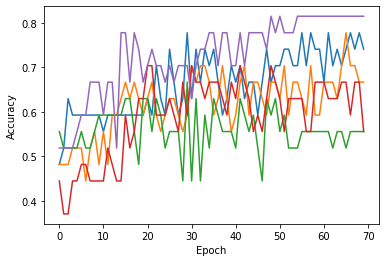

In [ ]:
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")